# UTKFace Efficientnet B3

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b3

from sklearn.metrics import classification_report, accuracy_score

# created library
import mydata
from mymodels import TransDataset, EfficientB3Model
import training

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
db = "UTKFace"
root = f"../../dataset/AAAI 2025/{db}/"
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test_with_skincolor.csv")

# Data Trainning

In [9]:
ycol="labels"
batch_size = 8
train_loader, valid_loader, test_loader = training.create_dataloaders(df_train, df_valid, df_test, ycol, batch_size)

H*W:  (200, 200)


Validation Accuracy: 0.8336 | Loss: 0.3946 | F1: 0.8152
Validation Accuracy: 0.8630 | Loss: 0.3326 | F1: 0.8523
Validation Accuracy: 0.8825 | Loss: 0.2816 | F1: 0.8763
Validation Accuracy: 0.8902 | Loss: 0.2636 | F1: 0.8904
Validation Accuracy: 0.8892 | Loss: 0.2602 | F1: 0.8933
Validation Accuracy: 0.8992 | Loss: 0.2332 | F1: 0.8988
Validation Accuracy: 0.9003 | Loss: 0.2415 | F1: 0.8965
Validation Accuracy: 0.8915 | Loss: 0.2658 | F1: 0.8861
Validation Accuracy: 0.8944 | Loss: 0.2523 | F1: 0.8958
Validation Accuracy: 0.8931 | Loss: 0.2586 | F1: 0.8945
Validation Accuracy: 0.8595 | Loss: 0.3832 | F1: 0.8722
Validation Accuracy: 0.8873 | Loss: 0.3088 | F1: 0.8783
Validation Accuracy: 0.9029 | Loss: 0.2576 | F1: 0.9013
Validation Accuracy: 0.8939 | Loss: 0.3125 | F1: 0.8862
Validation Accuracy: 0.8939 | Loss: 0.2833 | F1: 0.8946
Validation Accuracy: 0.9024 | Loss: 0.2735 | F1: 0.9070
Validation Accuracy: 0.8992 | Loss: 0.2683 | F1: 0.8958
Validation Accuracy: 0.9058 | Loss: 0.2462 | F1:

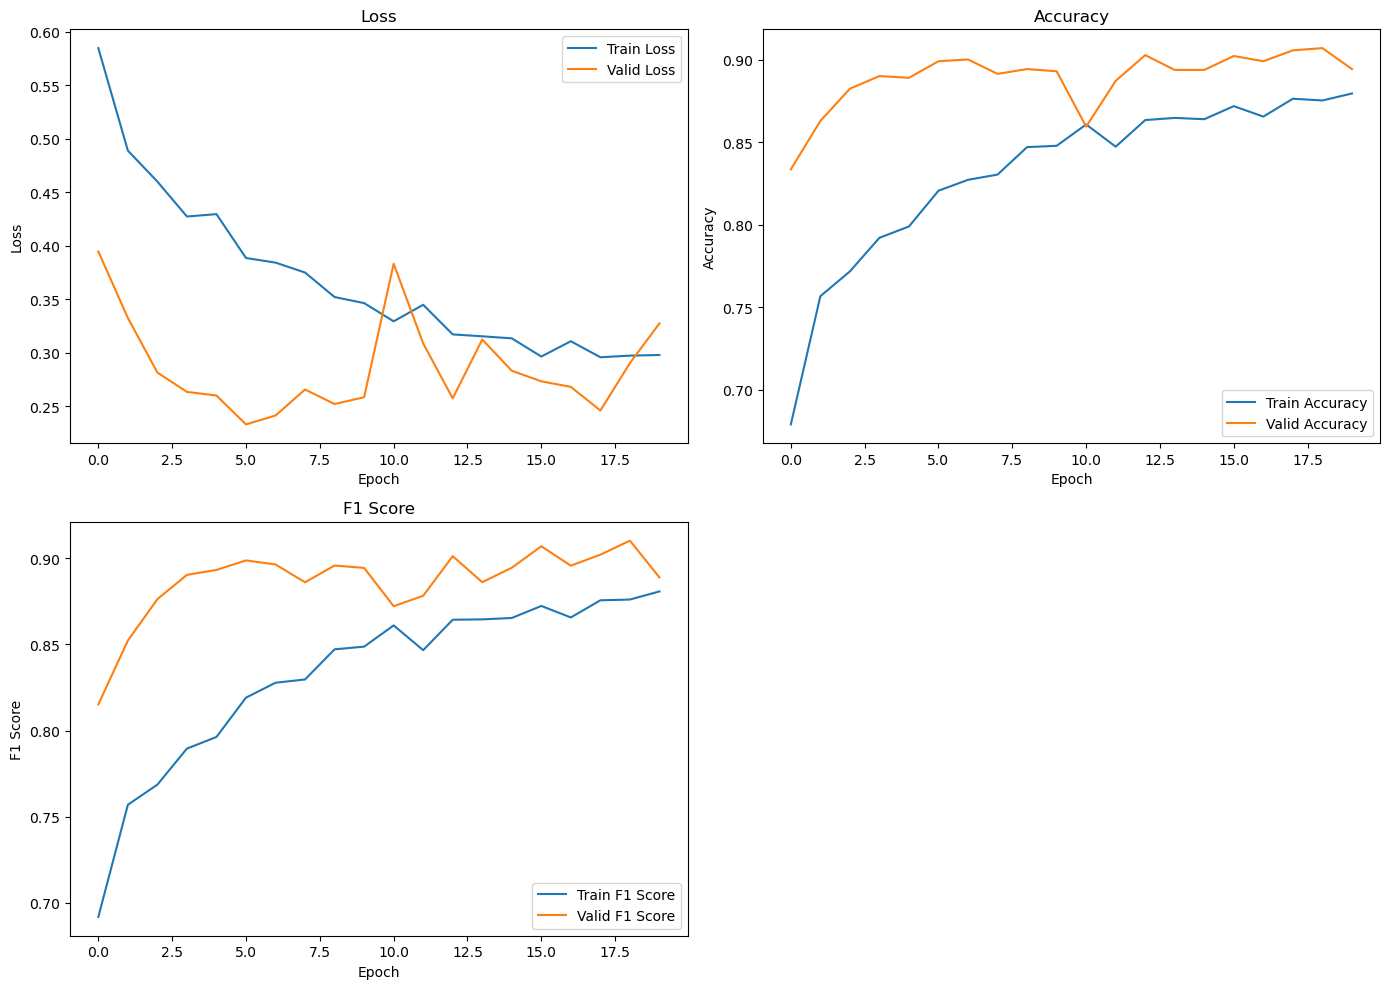

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_directory = f"{root}/model/efficientnet/"
model = EfficientB3Model().to(device) # model -> GPU

# Train the model
num_epochs = 20
lr = 0.0001
best_val_file = training.train_model(model, train_loader, valid_loader, model_save_directory, num_epochs=num_epochs, lr=lr)

##  Evaluation

In [11]:
model = EfficientB3Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
with torch.no_grad():
    test_predictions = []
    test_outputs = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
        outputs = model(inputs)
        # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
        test_outputs.append(outputs)
        test_predictions.extend(1 if x >= 0.5 else 0 for x in outputs) # Appendは１つ、extendは複数
        
df_test["predictions"] = test_predictions

In [12]:
training.test_classification_report(df_test)
df_test.to_csv(f"../../dataset/AAAI 2025/{db}/evaluation/df_test_ef3.csv", index=False)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2378
           1       0.94      0.86      0.90      2409

    accuracy                           0.90      4787
   macro avg       0.90      0.90      0.90      4787
weighted avg       0.90      0.90      0.90      4787

Skin tone 3: Accuracy 0.9202037351443124
Skin tone 0: Accuracy 0.8991803278688525
Skin tone 1: Accuracy 0.9260533104041273
Skin tone 2: Accuracy 0.8621533442088092
